# Training the YoloThreat model on the Danger Dataset

Here we will import Tuner.py, which manages the training loop, and YoloThreat, which is the customized version of yolo.
The datasets were produced by merging two datasets and labeled appropriately.
These datasets were generated in the `make_danger.py` script.

In [1]:
from tune import Tuner
from yolo_threat import YoloThreat

import torch
import numpy as np

Now to load in the dataset and do some sanity checks on the values.

In [2]:
Xtrain = torch.load('../data/danger/train.pt')
ytrain = torch.load('../data/danger/train_labels.pt')
Xtest = torch.load('../data/danger/test.pt')
ytest = torch.load('../data/danger/test_labels.pt')
print(Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape)

/tmp/ipykernel_154248/1365285054.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Xtrain = torch.load('../data/danger/train.pt')


torch.Size([8736, 3, 128, 128]) torch.Size([8736]) torch.Size([2185, 3, 128, 128]) torch.Size([2185])


/tmp/ipykernel_154248/1365285054.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ytrain = torch.load('../data/danger/train_labels.pt')
/tmp/ipykernel_154248/1365285054.p

In [3]:
print(Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape)

torch.Size([8736, 3, 128, 128]) torch.Size([8736]) torch.Size([2185, 3, 128, 128]) torch.Size([2185])


In [4]:
print(ytrain)

tensor([1., 1., 1.,  ..., 0., 0., 0.])


Below is the first image in the set. This is labeled as a threat as it is an offensive gesture.

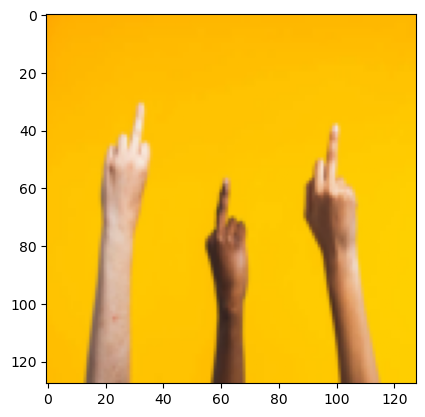

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(Xtrain[0].permute(1, 2, 0))
plt.show()

Now to actually train the model. The `Tuner` class will perform the training loop.
This will include a warmup of 6 epochs, where only the last two layers are updated.
After the warmup, all but the first 10 layers will be unfrozen for training.

The training is done with a learning rate of 0.01, with Binary Cross Entropy Loss, which is augmented with a penalty for changing the pretrained weights too much.
This penalty is calculated as the L2 norm of the difference in the weights multiplied by a scaling coefficient, lam = 0.01.

The training employs an early stopping mechaism with patience of 7 epochs.

In [6]:
tuner = Tuner(YoloThreat.load_new_model(),(Xtrain, ytrain))
model = tuner.tune(epochs=60, batch_size=50, lam=0.01)

Using cache found in /home/august/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-11-8 Python-3.12.2 torch-2.5.1+cu124 CPU

Fusing layers... 
YOLOv5n6 summary: 280 layers, 3239884 parameters, 0 gradients, 4.6 GFLOPs
Adding AutoShape... 


Epoch 0, Batch 34, Loss: 0.5860784649848938
Validation Loss: 18.78489539027214
Epoch 1, Batch 34, Loss: 0.45790529251098633
Validation Loss: 23.70819443464279
Epoch 2, Batch 34, Loss: 0.3778479993343353
Validation Loss: 47.10305154323578
Epoch 3, Batch 34, Loss: 0.3843616247177124
Validation Loss: 30.06601893901825
Epoch 4, Batch 34, Loss: 0.39716899394989014
Validation Loss: 50.996944308280945
Epoch 5, Batch 34, Loss: 0.32609158754348755
Validation Loss: 31.584547877311707
Epoch 6, Batch 34, Loss: 0.22721430659294128
Validation Loss: 26.585795283317566
Epoch 7, Batch 34, Loss: 0.34030935168266296
Validation Loss: 32.59498453140259
Epoch 8, Batch 34, Loss: 0.1979687660932541
Validation Loss: 39.47637164592743
Epoch 9, Batch 34, Loss: 0.27894604206085205
Validation Loss: 27.227200031280518
Epoch 10, Batch 34, Loss: 0.413086473941803
Validation Loss: 14.447809934616089
Epoch 11, Batch 34, Loss: 0.4168998599052429
Validation Loss: 10.699012130498886
Epoch 12, Batch 34, Loss: 0.15116730332

# Testing the model

Below we see the accuracy of the model on the test data and a untrained YoloThreat model for reference.

The trained model only acheives 69.15% accuracy, versus the untrained model's 50.21%

In [43]:
import torch
def test(model_t, X, y):
    model_t.eval()
    with torch.no_grad():
        y_pred = model_t.forward(X)
        y_pred = torch.sigmoid(y_pred)
        y_pred = (y_pred > 0.5).float().reshape(-1)
        return np.mean((y_pred == y).numpy())
    
print(test(model, Xtest, ytest))

0.691533180778032


In [44]:
naive_model = YoloThreat.load_new_model()
print(test(naive_model, Xtest, ytest))

Using cache found in /home/august/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-11-8 Python-3.12.2 torch-2.5.1+cu124 CPU

Fusing layers... 
YOLOv5n6 summary: 280 layers, 3239884 parameters, 0 gradients, 4.6 GFLOPs
Adding AutoShape... 


0.5020594965675057


In [35]:
#Save the model
torch.save(model.state_dict(), 'trained_model.pt')